# Visualization and Polynomial Fitting of Confirmed Cases in Dallas, Texas

The below notebook provides a visualization of the mean squared errors as well as the best fitting curve to the confirmed coronavirus cases in Dallas, Texas.

## Process

I first downloaded and retrieved data from the COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, or JHU CSSE COVID-19 Data (found [here](https://github.com/CSSEGISandData/COVID-19)). Next, I isolated the Texas cases by checking if the "Province_State" label was "Texas." I specified the "Dallas" row within that dataset. Since I had one row of values representing the number of confirmed cases in Dallas, Texas, I needed the features. In this case, it would be the number of days since January 22, 2020. I split this new matrix into a training and testing dataset (80/20). I calculated the training and testing Mean Squared Error for polynomials with degrees \[0, 30). After I identified the degree that minimized the testing error, I graphed that curve onto the plot along with a future trajectory.

In [1]:
import sys
sys.path.insert(0, '..')

from utils import data
import os
import sklearn
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')

In [2]:
# ------------ HYPERPARAMETERS -------------
BASE_PATH = '../COVID-19/csse_covid_19_data/'
# ------------------------------------------

In [3]:
confirmed = os.path.join(
    BASE_PATH, 
    'csse_covid_19_time_series',
    'time_series_covid19_confirmed_US.csv')
confirmed = data.load_csv_data(confirmed)

In [4]:
# Retrieves data from Dallas, Texas, and sorts into training/testing

texas_cases = confirmed[confirmed["Province_State"] == "Texas"]
dallas_cases = texas_cases[texas_cases["Admin2"] == "Dallas"]

df = data.filter_by_attribute(dallas_cases, "Admin2", "Dallas")
cases, _ = data.get_cases_chronologically_US(df)

reformatted_cases = np.zeros((np.shape(cases)[1], 2))

for i in range(np.shape(reformatted_cases)[0]):
    reformatted_cases[i] = [i, cases[0, i]]

x = reformatted_cases[:, 0]
x = x.reshape(-1, 1)
y = reformatted_cases[:, 1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [5]:
# Calculates training and testing error for polynomial equations with degrees [0, 30)

degrees = np.arange(30)
training_errors = np.zeros(30)
testing_errors = np.zeros(30)

for i, degree in enumerate(degrees):
    # Training Error
    poly = PolynomialFeatures(degree)
    x_train_poly = poly.fit_transform(x_train)
    
    pol_reg = LinearRegression()
    pol_reg.fit(x_train_poly, y_train)
    training_predictions = pol_reg.predict(x_train_poly)
    training_errors[i] = mean_squared_error(y_train, training_predictions)
    
    # Testing Error
    x_test_poly = poly.transform(x_test)
    testing_predictions = pol_reg.predict(x_test_poly)
    testing_errors[i] = mean_squared_error(y_test, testing_predictions)

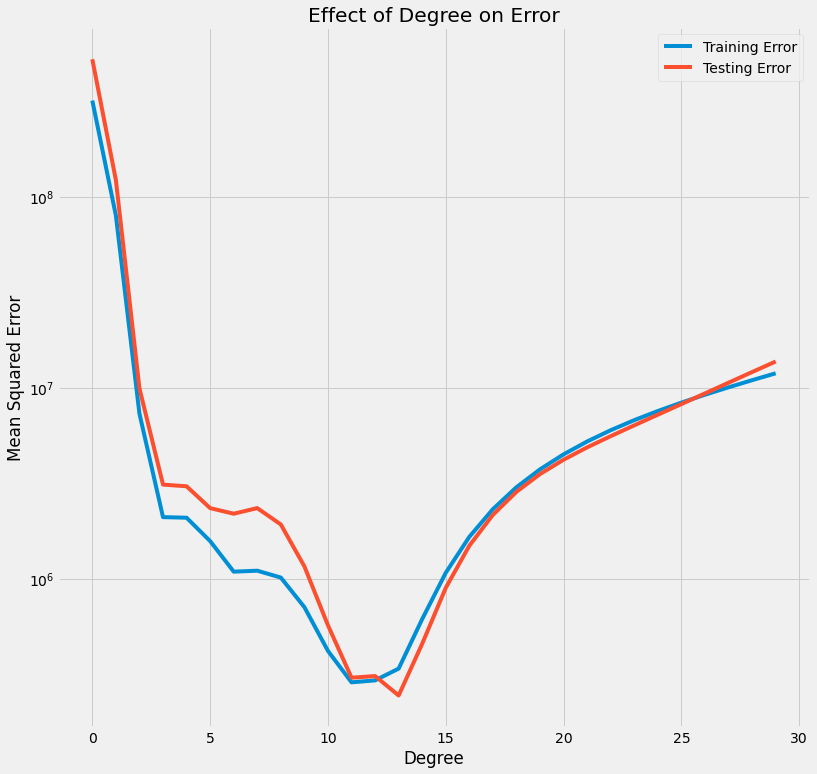

In [6]:
# Plots the training and testing errors

plt.figure(figsize=(12, 12))
plt.plot(degrees, training_errors, label="Training Error")
plt.plot(degrees, testing_errors, label="Testing Error")

plt.yscale('log')

plt.legend()

plt.xlabel("Degree")
plt.ylabel("Mean Squared Error")
plt.title("Effect of Degree on Error")
plt.show()

In [7]:
# Identifies the fitted line and trajectory

min_testing_error_degree = degrees[np.argmin(testing_errors)]

# Fitting according to training
poly = PolynomialFeatures(min_testing_error_degree)
x_train_poly = poly.fit_transform(x_train)

pol_reg = LinearRegression()
pol_reg.fit(x_train_poly, y_train)

# Predicts up until present
x_present = np.arange(0, np.shape(x)[0]).reshape(-1, 1)
x_present_poly = poly.transform(x_present)
x_present_predictions = pol_reg.predict(x_present_poly)

# Predicts 60 days past present
trajectory = np.arange(np.shape(x)[0], np.shape(x)[0]+60).reshape(-1, 1)
trajectory_poly = poly.transform(trajectory)
trajectory_predictions = pol_reg.predict(trajectory_poly)

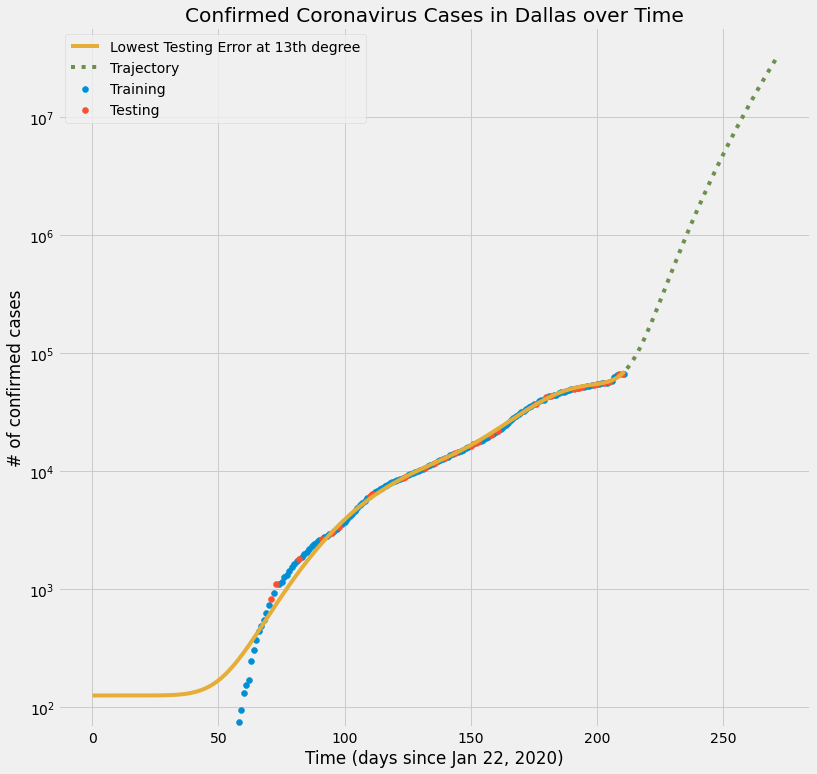

In [8]:
# Plots training/testing points along with the fitted line and trajectory

plt.figure(figsize=(12, 12))
plt.scatter(x_train, y_train, color='#008fd5', label='Training')
plt.scatter(x_test, y_test, color='#fc4f30', label='Testing')
plt.plot(x_present, x_present_predictions, color='#e5ae38',
         label='Lowest Testing Error at '+str(min_testing_error_degree)+"th degree")
plt.plot(trajectory, trajectory_predictions, color='#6d904f', linestyle=':', label='Trajectory')

plt.ylabel('# of confirmed cases')
plt.xlabel("Time (days since Jan 22, 2020)")

plt.yscale('log')
plt.legend()
plt.title("Confirmed Coronavirus Cases in Dallas over Time")
plt.show()